# Using Excel from Pandas

I generally prefer doing all data transformations in python, but sometimes you're handed **MS Excel** files. Pandas supports these files in (most) shapes. You can find [more documentation here](https://xlsxwriter.readthedocs.io/working_with_pandas.html) in using pandas to manipulate excel files.

When possible, reading all worksheets into dataframes and joining/merging them where possible is best.

In [2]:
import pandas as pd
import os
import seaborn as sns
sns.set()

# Several excel files in data folder, read them together
root_path = 'data/FitBit'
df_list = []
for f in os.listdir('data/FitBit'):
    df_list.append(pd.read_excel(f"{root_path}/{f}"))

# Efficient way of appending several dataframes at once 
df = pd.concat(df_list)
print(f"len: {df.shape[0]}")
df.head()

len: 186


,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,2015-02-02,747,0,0.00,0,"1,440",0,0,0,0
1,2015-02-03,867,"3,375",1.10,0,"1,356",42,28,14,164
2,2015-02-04,887,"3,625",1.19,0,"1,332",63,34,11,196
3,2015-02-05,846,"2,108",0.69,0,"1,352",65,18,5,143
4,2015-02-06,969,"6,107",2.02,0,"1,284",71,66,19,300


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186 entries, 0 to 30
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    186 non-null    object 
 1   Calories Burned         186 non-null    object 
 2   Steps                   186 non-null    object 
 3   Distance                186 non-null    float64
 4   Floors                  186 non-null    int64  
 5   Minutes Sedentary       186 non-null    object 
 6   Minutes Lightly Active  186 non-null    int64  
 7   Minutes Fairly Active   186 non-null    int64  
 8   Minutes Very Active     186 non-null    int64  
 9   Activity Calories       186 non-null    int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 16.0+ KB


ValueError: max must be larger than min in range parameter.

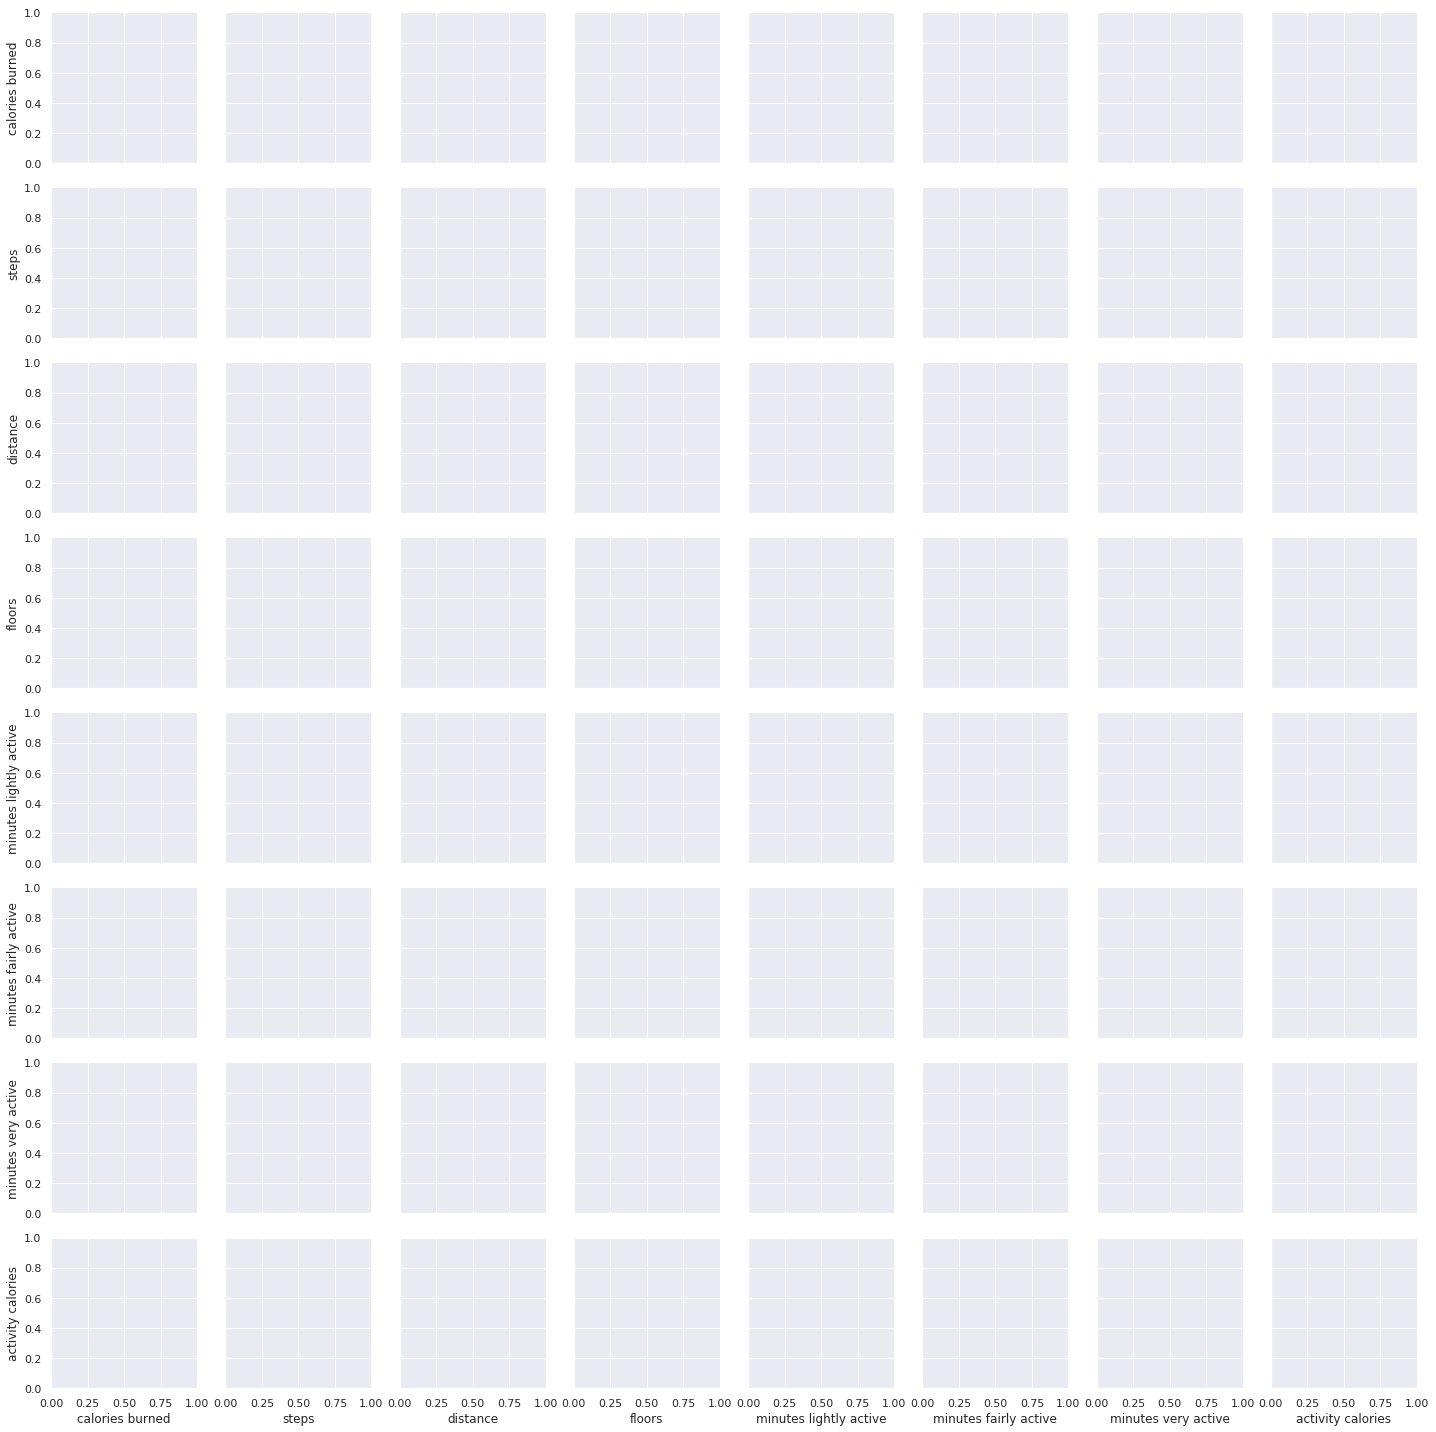

In [4]:
# Columns names are capitalized, this is annoying
df.columns = [x.lower() for x in df.columns]
# Date should be a timestamp, not str
df.date = pd.to_datetime(df.date)
# Steps and calories should be numbers
for c in ['steps', 'calories burned']:
    df[c] = df[c].str.replace("\D+", "").astype(float)

# Visualize dataset
sns.pairplot(df)

### What do we see?

- floors is useless

- There are a bunch of days where there's 0 steps/activity. Seem to be missing data.

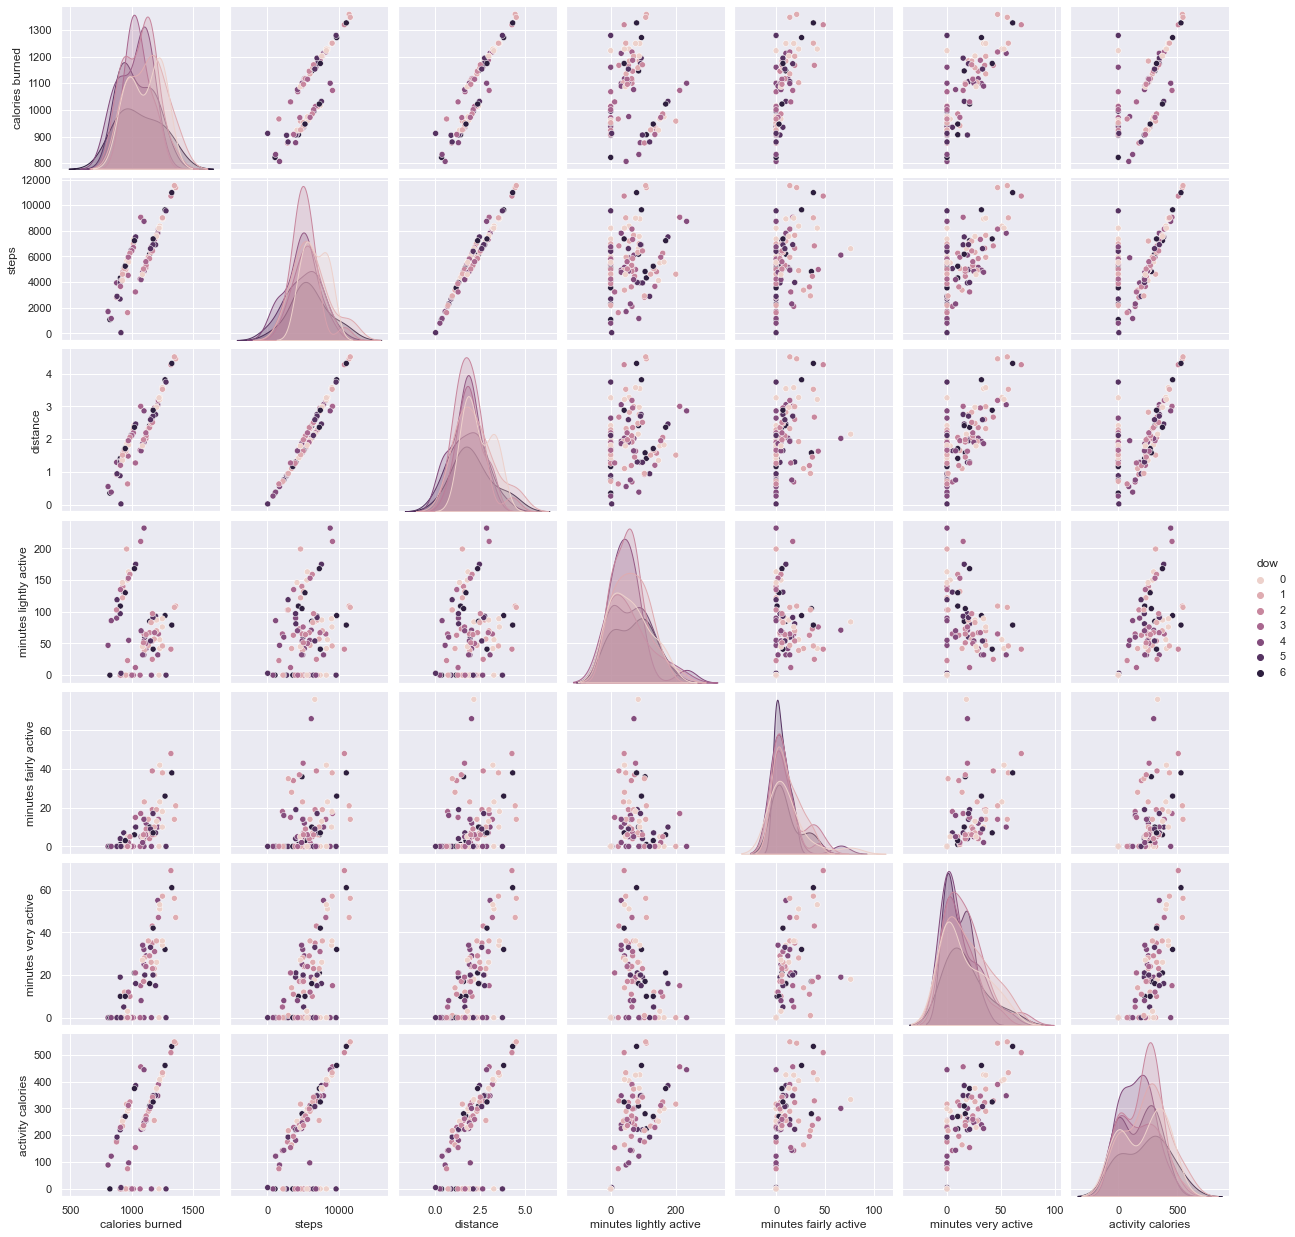

In [4]:
df = df.drop('floors', axis=1)
df = df.loc[df.steps > 0].reset_index(drop=True)

# Make a day of week column
df['dow'] = df.date.dt.dayofweek

sns.pairplot(df, hue='dow')

# Data Pipeline

Your data pipeline should have the following properties:

- **One-way.** Data starts from original data and is processed towards final data.

Here, we have 8 

```
File1 \
File2 --concat--> --fix types--> remove nulls -> analysis
File3 /
```

- **Repeatable.** In a single click you should be able to reproduce the whole pipeline from the original data

Here things break along the way if we try to run `df.drop('floors', 1)` from a later point, but it always works as a fresh re-run

- **Updateable.** If there is data added to the data source, the pipeline should support it seamlessly.

- **Single Configuration.** If there is a configuration for the pipeline (how many days to keep, what columns to fix, etc.) it should all be in the same place towards the beggining of the code file.

# The Debunkathon

A great way to gain statistical literacy is to learn **what not to do**.

In this spirit, you now get to hear me rant about bad statistics for the rest of this lecture!

Our first victim is this chart from [this WSJ op-ed](https://www.wsj.com/articles/ending-americas-slow-growth-tailspin-1462230818) by noted economist [John Cochrane](https://en.wikipedia.org/wiki/John_H._Cochrane):

![](cross_sec_pretty.png)


### Index Variables

We saw in project 1 how forgetting a measure from an optimization target led to this measure being implicitly maximized/minimized in the worst possible direction.

A common solution to this problem is creating an **index variable** -- a variable that merges many metrics together. The [Human Development Index](https://en.wikipedia.org/wiki/Human_Development_Index) is an example.

### The evils of a log-scale axis

This plots the world bank ["Ease of Doing Business"](https://en.wikipedia.org/wiki/Ease_of_doing_business_index) (EDB) score against GDP per Capita. John uses this to make a ridiculous log-linear extrapolation that increasing the United States' EDB score would significantly increase its GDP per capita.

The data looks appropriately insane if we make the graph y-axis linear instead of logarithmic, as other economist Brad DeLong charts: 

![](https://i0.wp.com/www.singlelunch.com/wp-content/uploads/2019/04/6a00e551f08003883401bb08f71316970d.jpg?w=549&ssl=1)

### We can't extrapolate the EDB index past 100


The [EDB index][9] is fundamentally not made as a way measure distance between countries. By it's made to [rank countries][10] against each other. 

EDB is an "ordinal" numbering, not a "cardinal" numbering.

The EDB is made of statistics like "time to start a business" or "cost of construction permits". If you're blending hours and dollars together into one number, it quickly stops making sense to have a notion of "distance" between two index values, because the cardinality of the input numbers is lost when blending different value types.

The World Bank instead ranks countries by which percentile they fall into on each statistic to make the final index.

The [Frontier Score][11] basically calculates the average percentile distance from the best score on each value.

If the US were to have a frontier score of 100, it would have the business procedures of New Zealand, the border compliance of France, and the protection to minority investors of Cambodia. But somehow it would end up with **more than twice the GDP per capita** of any of those countries.


 [9]: https://data.worldbank.org/indicator/IC.BUS.EASE.XQ
 [10]: http://siteresources.worldbank.org/EXTAFRSUMAFTPS/Resources/db_indicators.pdf
 [11]: http://www.doingbusiness.org/content/dam/doingBusiness/media/Annual-Reports/English/DB17-Chapters/DB17-DTF-and-DBRankings.pdf

# Redoing the study ourselves

If the data has a nonlinear fit and the frontier score depends on it, instead of doing a log-linear extrapolation as was done before, we can simply fit the model ourselves.

We can get the **"Doing Business Score"** data and the **GDP** data from the World Bank.

In [5]:
# Read "Doing Business Score" data from World Bank
frt = pd.read_csv('data/frontier distance.csv')
frt.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,Ease of doing business score (0 = lowest perfo...,IC.BUS.DFRN.XQ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,Ease of doing business score (0 = lowest perfo...,IC.BUS.DFRN.XQ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,39.25519,38.93563,37.13062,44.20343,44.06497,NaN,NaN
2,Angola,AGO,Ease of doing business score (0 = lowest perfo...,IC.BUS.DFRN.XQ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,37.57368,37.65132,39.00774,41.20205,41.28838,NaN,NaN


In [6]:
# Same as above with World Bank GDP Data
gdp = pd.read_csv('data/GDPpc.csv')
gdp.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,24630.939270,23512.602600,24984.279450,24709.602260,25018.308950,25528.403780,25796.380250,25251.639680,25655.102020,NaN
1,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,59.777327,59.878153,58.492874,78.782758,82.208444,101.290471,...,444.184404,550.514974,599.297630,648.511070,647.966461,625.339539,590.076474,549.582760,550.068459,NaN
2,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3117.896944,3585.905553,4615.867475,5102.489969,5258.407376,5412.692348,4170.730358,3509.604211,4100.289786,NaN


### Tidy data model

The data clearly doesn't respect the **Tidy Data** model. One observation should be **one country/one year** and the columns should be **one column per indicator**.

Shame on the world bank! Let's do their job for them.

First, we can use **pivot** to de-pivot-table-ify the EDB table:

In [7]:
# Remove irrelevant columns
frt = frt.drop(['Country Code', 'Indicator Code'], 1)
# Pivot categories to categorical columns
frt = pd.DataFrame(
        frt.pivot(index='Indicator Name', 
                  columns='Country Name'
        ).unstack(
        ).reset_index(drop=False)
)
frt = frt.drop('Indicator Name', 1)
frt.columns = ['Year', 'Country', 'FrontierDistance']
frt.head(3)

,Year,Country,FrontierDistance
0,1960,Afghanistan,NaN
1,1960,Albania,NaN
2,1960,Algeria,NaN


Same with the **GDP** table:

In [8]:
# Same as above with World Bank GDP Data
gdp = gdp.drop(['Country Code', 'Indicator Code'], 1)
# One row per country per year with GDP
gdp = pd.DataFrame(
        gdp.pivot(index='Indicator Name', 
                 columns='Country Name'
      ).unstack(
      ).reset_index(drop=False)
)
gdp = gdp.drop('Indicator Name', 1)
gdp.columns = ['Year', 'Country', 'GDPperCap']
gdp.head(3)

,Year,Country,GDPperCap
0,1960,Afghanistan,59.777327
1,1960,Albania,NaN
2,1960,Algeria,244.824806


Now that both data tables are indexed by **Year/Country** we can merge them on it

In [9]:
frt = frt.merge(gdp, how='inner', on=['Year', 'Country'])
# Drop missing observations
frt = frt.dropna()
frt = frt.sort_values(by='FrontierDistance')

You'll learn how to do the following in module 3, for now just enjoy the code and plot:

In [13]:
import statsmodels.api as sm

### Regression without a constant makes more sense
### since frontier score of 0 should have 0 GDP
# X = sm.add_constant(frt['FrontierDistance'])
X = frt[['FrontierDistance']].copy()

X['FrontierDistance2'] = X['FrontierDistance'] ** 2

est = sm.OLS(frt['GDPperCap'], X).fit()
# Regression Summary
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              GDPperCap   R-squared (uncentered):                   0.656
Model:                            OLS   Adj. R-squared (uncentered):              0.655
Method:                 Least Squares   F-statistic:                              657.2
Date:                Wed, 09 Dec 2020   Prob (F-statistic):                   2.05e-160
Time:                        12:23:30   Log-Likelihood:                         -7493.0
No. Observations:                 691   AIC:                                  1.499e+04
Df Residuals:                     689   BIC:                                  1.500e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
FrontierDistance   -578.7264     42.751    -13.537      0.000    -662.665    -494.788
FrontierDistance2    12.4010      0.642     19.331      0.000      11.141      13.660
==============================================================================
Omnibus:                      343.924   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3228.029
Skew:                           2.017   Prob(JB):                         0.00
Kurtosis:                      12.790   Cond. No.                         373.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
est.predict(exog=[100, 10000])

array([66136.88524349])

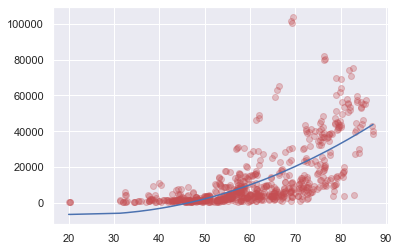

In [17]:
import matplotlib.pyplot as plt

plt.scatter(frt['FrontierDistance'], frt['GDPperCap'], color='r', alpha=0.3)
plt.plot(frt['FrontierDistance'], est.predict(), '-')
plt.show()